In [1]:
# Input: 
path_data = '../../01 data/shampoo.csv'
target_var = 'Sales'
split_ratio_train = 0.65
split_ratio_val = 0.15
split_ratio_test = 0.2

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

In [3]:
# Load data
data = pd.read_csv(path_data)
print(data.shape)
data.head(3)

(36, 2)


,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1


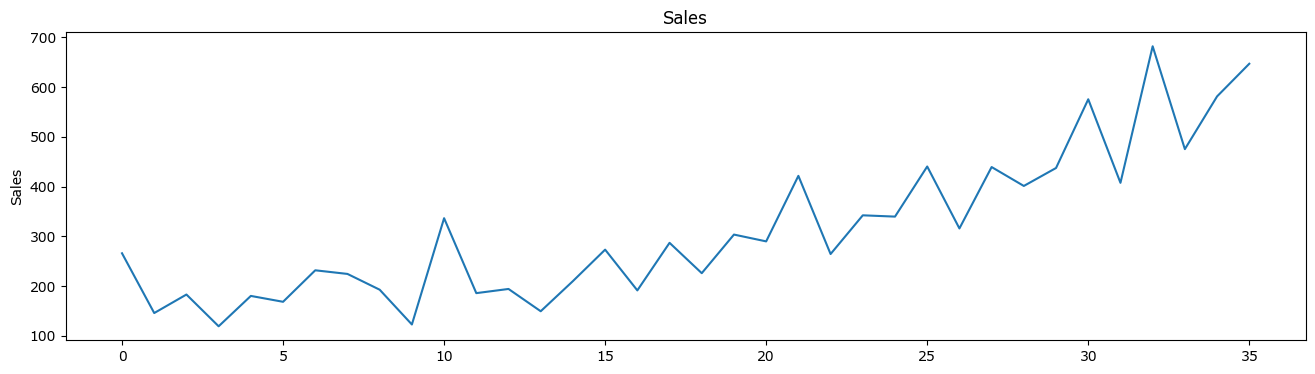

In [4]:
# Visualize
plt.figure(figsize=(16,4))
sns.lineplot(data=data, x=data.index, y=target_var)
plt.title(target_var)
plt.show()

In [9]:
# Select features
# If univariate, select the only target var.
data = data[[target_var]]
# If multivariate, select the target var and features.

In [10]:
# Train, val, test split
end_train = int(round(split_ratio_train * len(data), 0))
# end_val is not needed if test split is not made here
end_val = int(round((split_ratio_val + split_ratio_train) * len(data), 0))

# Stationarity

Stationary: consistent mean and variance overtime.
There is no seasonal and trend effects.

Stationary types:
- strict stationary
- seasonal stationary
- trend stationary

Stationary check:
1. visually observe the time series
2. visually observe the histogram plot if it conforms gaussian/normal distribution
3. summary statistics
4. statistical tests

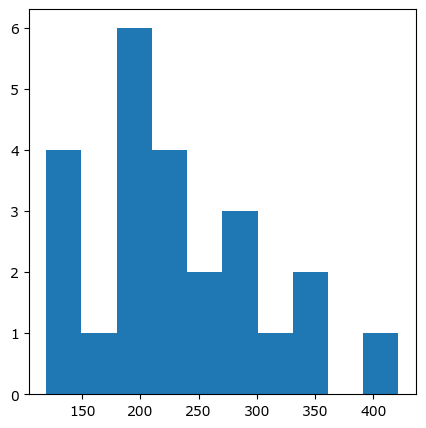

In [11]:
plt.figure(figsize=(5,5))
plt.hist(data.loc[:end_train, target_var])
plt.show()

Augmented Dickey-Fuller test (unit root test)
- Null Hypothesis (H0): the time series has a unit root, meaning it is non-stationary.
- Alternate Hypothesis (H1): the time series does not have a unit root, meaning it is stationary.

The result below:
- ADF Statistics, The more negative, the more likely to reject the null hypothsis
- p-value > 0.05, it is non-stationary.

In [12]:
adfuller_test = adfuller(data.loc[:end_train, target_var])
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.291559
p-value: 0.633025
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643


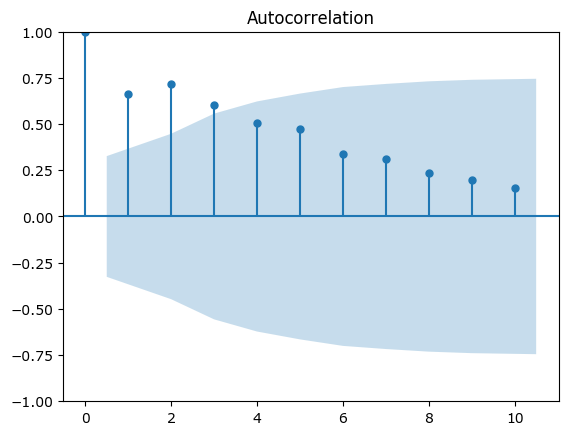

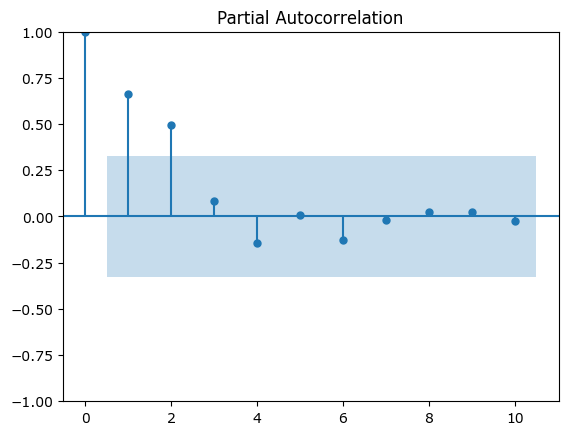

In [13]:
# Autocorrelation
plot_acf(data[target_var], lags=10)
plot_pacf(data[target_var], lags=10)
# pacf shows that the dependence can be captured until lag 2
plt.show()

In [14]:
# Function to make stationary
def difference(dataset: pd.Series, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return pd.Series(diff)


In [15]:
# Transform data to be stationary
data = difference(data[target_var].values, 1)

# If it is a multivariate problem, then transform the other variables too based on the judgement.
# Then, combine them back as a data frame
data = pd.DataFrame(data)
data.columns = [target_var]
data.head()

,Sales
0,-120.1
1,37.2
2,-63.8
3,61.0
4,-11.8


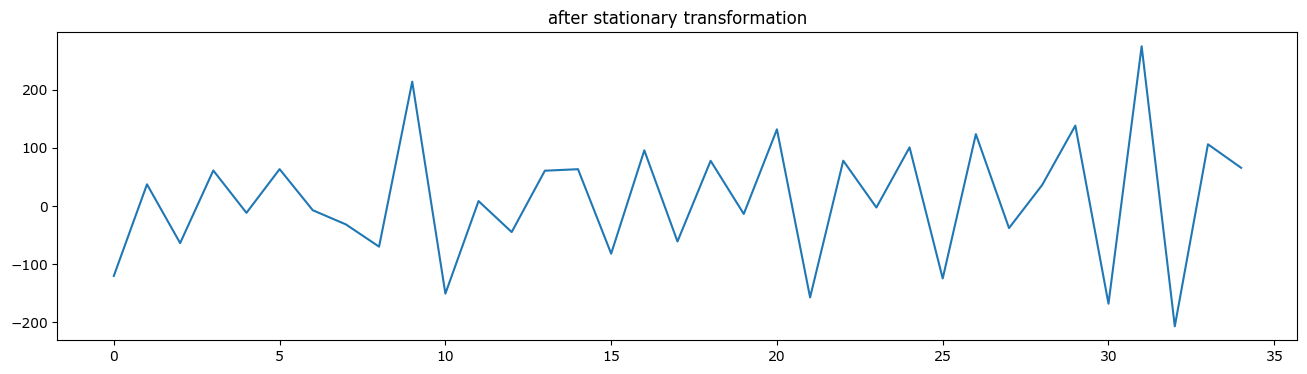

In [16]:
# Visualize stationary
plt.figure(figsize=(16,4))
plt.plot(data)
plt.title('after stationary transformation')
plt.show()

In [17]:
# Test ADFuller again
adfuller_test = adfuller(data[:end_train])
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f' % (key, value))
# The p-value is now < 0.05, meaning that it is stastionary now.

ADF Statistic: -10.272360
p-value: 0.000000
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643


In [18]:
# Standard scaler
scaler = StandardScaler()
scaler.fit(data.iloc[:end_train, :])
# Save the scaler
# pickle.dump(scaler, open('../../03 outputs/univariate/01/time_scaler.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Load standard scaler
scaler = pickle.load(open('../../03 outputs/univariate/01/time_scaler.pickle', 'rb'))

In [19]:
# Feature engineering with lag time
def feature_shift_time(data: pd.DataFrame, lag=1, n_out=1, dropnan=True):
    var_names = list(data.columns)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    column, feature = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        column.append(df.shift(i))
        feature += [f'{v}(t-{i})' for v in var_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        column.append(df.shift(-i))
        if i == 0:
            feature += [f'{v}(t)' for v in var_names]
        else:
            feature += [f'{v}(t+{i})' for v in var_names]
    # put it all together
    agg = pd.concat(column, axis=1)
    agg.columns = feature
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
### Set the n_lag based on the PACF
n_lag = 2

# Scale
data_prep = data.copy()
data_prep = pd.DataFrame(scaler.transform(data), columns=data_prep.columns)

# Feature engineering with lag time
data_prep = feature_shift_time(data_prep, lag=n_lag, n_out=1)

# Remove features at time t
drop_col = [c for c in data_prep.columns if '(t)' in c and c != target_var]
data_prep = data_prep.drop(columns=[])

print(data_prep.shape)
data_prep.head(3)

(33, 3)


,Sales(t-2),Sales(t-1),Sales(t)
2,-1.374845,0.377446,-0.747674
3,0.377446,-0.747674,0.642573
4,-0.747674,0.642573,-0.168405


In [21]:
# Create X and y
X_col = [c for c in data_prep if '(t)' not in c]
y_col = [f'{target_var}(t)']

X_train = data_prep.loc[:end_train, X_col]
X_val = data_prep.loc[end_train+1:end_val, X_col]
X_test = data_prep.loc[end_val+1:, X_col]

y_train = data_prep.loc[:end_train, y_col]
y_val = data_prep.loc[end_train+1:end_val, y_col]
y_test = data_prep.loc[end_val+1:, y_col]

In [22]:
# Save
X_train.to_csv('../../03 outputs/univariate/01/X_train.csv')
y_train.to_csv('../../03 outputs/univariate/01/y_train.csv')
X_val.to_csv('../../03 outputs/univariate/01/X_val.csv')
y_val.to_csv('../../03 outputs/univariate/01/y_val.csv')
X_test.to_csv('../../03 outputs/univariate/01/X_test.csv')
y_test.to_csv('../../03 outputs/univariate/01/y_test.csv')

In [23]:
# Reshape input to be 3D [n of samples, n of lag timesteps, n of features]
n_features = len(data.columns)
X_train = X_train.values.reshape((X_train.shape[0], n_lag, n_features))
X_val = X_val.values.reshape((X_val.shape[0], n_lag, n_features))
X_test = X_test.values.reshape((X_test.shape[0], n_lag, n_features))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(22, 2, 1) (22, 1) (6, 2, 1) (6, 1) (5, 2, 1) (5, 1)


In [25]:
X_train[:5]

array([[[-1.37484538],
        [ 0.37744557]],

       [[ 0.37744557],
        [-0.74767449]],

       [[-0.74767449],
        [ 0.64257288]],

       [[ 0.64257288],
        [-0.16840476]],

       [[-0.16840476],
        [ 0.66819442]]])

In [26]:
y_train[:5]

,Sales(t)
2,-0.747674
3,0.642573
4,-0.168405
5,0.668194
6,-0.118276


In [27]:
# Save
np.save('../../03 outputs/univariate/01/X_train.npy', X_train)
np.save('../../03 outputs/univariate/01/y_train.npy', y_train)
np.save('../../03 outputs/univariate/01/X_val.npy', X_val)
np.save('../../03 outputs/univariate/01/y_val.npy', y_val)
np.save('../../03 outputs/univariate/01/X_test.npy', X_test)
np.save('../../03 outputs/univariate/01/y_test.npy', y_test)